In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn import pipeline
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import f1_score

import matplotlib.pyplot as  plt
%matplotlib inline
plt.style.use('bmh')

%matplotlib inline

import graphviz
import os
os.environ['PATH'] = os.environ['PATH'] + ';C:/Program Files (x86)/Graphviz2.38/bin'


### <span style="color:#0000CD">**0. Adição de novas palavras ao Stopwords** </span>

In [3]:
import nltk
from nltk.corpus import stopwords
stopwords_nltk = nltk.corpus.stopwords.words('portuguese')

stopwords_nltk.append('afim')
stopwords_nltk.append('kv')
stopwords_nltk.append('mw')
stopwords_nltk.append('apos')
stopwords_nltk.append('sao')
stopwords_nltk.append('atraves')
stopwords_nltk.append('seguintes')
stopwords_nltk.append('anos')
stopwords_nltk.append('devido')
stopwords_nltk.append('ccl')
stopwords_nltk.append('cges')
stopwords_nltk.append('la')
stopwords_nltk.append('ser')
stopwords_nltk.append('serao')
stopwords_nltk.append('sera')
stopwords_nltk.append('nao')
stopwords_nltk.append('ii')
stopwords_nltk.append('iii')


### <span style="color:#0000CD">**1. Diretórios Mapeados**</span>

In [4]:
datapath = '../../Data/Processed/dados_treinoteste.parquet'

model_score_file = '../../Data/Modeling/score_sin.parquet'
model_file = '../../Data/Modeling/modelo_previsao.jbl'

### <span style="color:#0000CD">**2.Transferência Dados para DataFrame**</span>

In [5]:
dataframe = pd.read_parquet(datapath)


#### <span style="color:#FF4500">**2.1 Formato do DataFrame**</span>

In [6]:
print('shape:', dataframe.shape)
print('columns:', dataframe.columns)


shape: (22717, 3)
columns: Index(['id', 'dsc_texto', 'tip_supervisao'], dtype='object')


### <span style="color:#0000CD">**3. Treino / Teste** </span>

In [7]:
X = dataframe['dsc_texto'].values.reshape(-1).tolist()
Y = (dataframe['tip_supervisao'].values.reshape(-1) == 'oper').tolist()

# Dividir 20% dos dados para o conjunto out-of-sample de teste
Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split( X,
                                                                 Y,
                                                                 test_size=0.22,
                                                                 random_state=0,
                                                                 stratify= Y 
                                                                 )

# Xtrain e Xtest = Texto
# Ytrain e Ytest = Classe

In [8]:
# Objeto de validacao cruzada
cvfold = model_selection.StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True, )


### <span style="color:#0000CD">**4.Construção do Pipeline**</span>

In [9]:
# Configure Pipeline
model_dict = {
    'RandomForest': ensemble.RandomForestClassifier(n_estimators=10, max_features='sqrt'),
    'LogisticRegr': LogisticRegression(max_iter=10000),
    'kNN': KNeighborsClassifier(weights='distance'),
    'SVM': SVC(probability=False, gamma='auto'),
}

model_conf = {
 'RandomForest': {
 'Model__max_depth': [4, 6],
 'Model__n_estimators': [10, 50], 
    },
    'LogisticRegr': {
        'Model__C': [0.001, 0.1, 1, 10],
    },
    'kNN': {
        'Model__n_neighbors': [5, 10, 20],
    },
    'SVM': {
        'Model__kernel': ['rbf',],
        'Model__C' : [0.1, 1, 10],
    }
}

scorer = metrics.make_scorer(metrics.f1_score)   
            

In [10]:
data_atual = datetime.datetime.now()
print(data_atual)

2020-09-10 16:21:18.017878


In [11]:
model_list = {}


for model_name in model_dict.keys():
    conf_train_pipe = [
        ('TfIDf', TfidfVectorizer(Xtrain,stop_words=stopwords_nltk)),
        ('Model', model_dict[model_name]),
    ]
    
    #cross_val_score
    # Create Pipeline
    model_pipe = pipeline.Pipeline(conf_train_pipe)
    param_grid = model_conf[model_name].copy()
    model_pipe = model_selection.GridSearchCV(model_pipe, param_grid,
                                              scoring=scorer,
                                              n_jobs=1,
                                              cv=cvfold,
                                              return_train_score = True,)
    
    

    model_pipe.fit(Xtrain, Ytrain)
    model_list[model_name] = model_pipe 

In [12]:
data_atual = datetime.datetime.now()
print(data_atual)

2020-09-10 17:39:17.929503


### <span style="color:#0000CD">**5. Curva ROC** </span>

Text(0, 0.5, 'Taxa de Detecção')

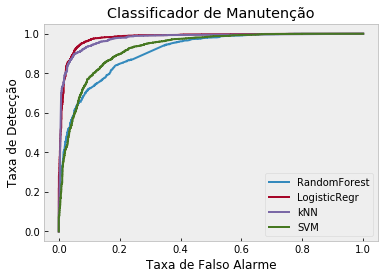

In [13]:
plt.figure(figsize=(6,4))

for model_name in model_dict.keys():
    model = model_list[model_name]
    # estimate Y
    if model_name in ['RandomForest', 'SVM']:
        final_model = LogisticRegressionCV(Cs=20,cv=5)
        if model_name == 'SVM':
            Yhat_train = model.decision_function(Xtrain)
            Yhat = model.decision_function(Xtest)
        else:
            Yhat_train = model.predict_proba(Xtrain)[:,1]
            Yhat = model.predict_proba(Xtest)[:,1]
            
        final_model.fit(Yhat_train.reshape(-1, 1), Ytrain)
        Yhat  = final_model.predict_proba(Yhat.reshape(-1,1))[:,1]
        Ypred = final_model.predict(Yhat.reshape(-1,1))
    else:
        Yhat = model.predict_proba(Xtest)[:,1]
        Ypred = model.predict(Xtest)
    
    
    fpr, tpr, thr = metrics.roc_curve(Ytest, Yhat)
    auc = metrics.roc_auc_score(Ytest, Yhat)
    f1 = metrics.f1_score(Ytest, Ypred)
    label = model_name # + " AUC: %.3f - F1: %.3f"%(auc, f1)
    plt.plot(fpr, tpr, '-', lw=2, label=label)

    
plt.legend()
plt.title('Classificador de Manutenção')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção')

### <span style="color:#0000CD">**6. Distribuição de Probabilidades do Modelo** </span>

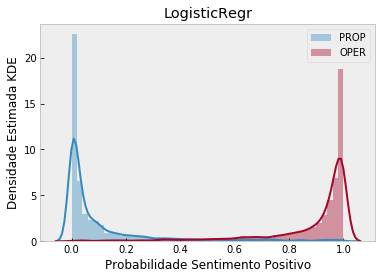

In [14]:
model_name = 'LogisticRegr'
model = model_list[model_name]
Yhat = model.predict_proba(Xtest)[:,1]

for i in [False, True]:
    # 2 Classes case
    sns.distplot(Yhat[np.array(Ytest) == i], label=['PROP','OPER'][i])

plt.title(model_name)
plt.ylabel('Densidade Estimada KDE')
plt.xlabel('Probabilidade Sentimento Positivo')
plt.grid()
plt.legend()

### <span style="color:#0000CD">**7. Matriz de Confusão** </span>

In [15]:
model_name = 'LogisticRegr'


model = model_list[model_name]
Ypred = model.predict(Xtest)

col_names = ['Model ' + s for s in ['prop','oper']]
idx_names = ['Real ' + s for s in ['prop','oper']]

cmat = metrics.confusion_matrix(Ytest, Ypred)
cmat = pd.DataFrame(cmat, index=idx_names,
                              columns=col_names)
cmat['Real Total'] = cmat.sum(axis=1)
cmat.loc['Model Total',:] = cmat.sum(axis=0)
cmat = cmat.astype(int)
cmat


,Model prop,Model oper,Real Total
Real prop,2325,167,2492
Real oper,147,2359,2506
Model Total,2472,2526,4998


In [16]:
print(metrics.classification_report(Ytest, Ypred))

              precision    recall  f1-score   support

       False       0.94      0.93      0.94      2492
        True       0.93      0.94      0.94      2506

    accuracy                           0.94      4998
   macro avg       0.94      0.94      0.94      4998
weighted avg       0.94      0.94      0.94      4998



### <span style="color:#0000CD">**8. Coeficientes de Regressão** </span>

Text(0.5, 0, 'Coeficiente')

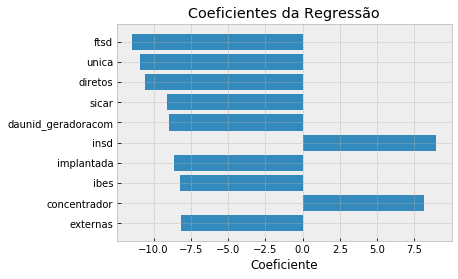

In [17]:
plt.figure(figsize=(6,4))

nshow = 10
model_name = 'LogisticRegr'
model = model_list[model_name].best_estimator_.steps[1][1]
vocabulary = model_list[model_name].best_estimator_.steps[0][1].vocabulary_
vocabulary = np.array(list(vocabulary.keys()))

coefs = model.coef_[0]

idx = np.argsort(np.abs(coefs))[-nshow:]

yaxis = np.arange(nshow)


plt.barh(yaxis, coefs[idx])
plt.yticks(yaxis, vocabulary[idx])

plt.title('Coeficientes da Regressão')
plt.xlabel('Coeficiente')


### <span style="color:#0000CD">**9. Explicação pela Árvore de Decisão** </span>

Text(0.5, 0, 'Importância Relativa')

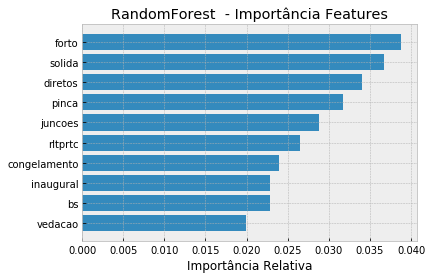

In [18]:
plt.figure(figsize=(6,4))

nshow = 10
model_name = 'RandomForest'
model = model_list[model_name].best_estimator_.steps[1][1]
vocabulary = model_list[model_name].best_estimator_.steps[0][1].vocabulary_
vocabulary = np.array(list(vocabulary.keys()))

coefs = model.feature_importances_

idx = np.argsort(np.abs(coefs))[-nshow:]

yaxis = np.arange(nshow)


plt.barh(yaxis, coefs[idx])
plt.yticks(yaxis, vocabulary[idx])

plt.title(model_name + '  - Importância Features')

plt.xlabel('Importância Relativa')

### <span style="color:#0000CD">**10. Exportação do Resultado** </span>

In [33]:
model_name = 'LogisticRegr'

test_data = [Xtest, Ytest,]
df_cols = ['dsc_texto', 'tip_predicao'] 
for model_name in model_dict.keys():
    model = model_list[model_name]
    if model_name in ['RandomForest', 'SVM']:
        final_model = LogisticRegressionCV(Cs=20,cv=5)
        if model_name == 'SVM':
            Yhat_train = model.decision_function(Xtrain)
            Yhat = model.decision_function(Xtest)
        else:
            Yhat_train = model.predict_proba(Xtrain)[:,1]
            Yhat = model.predict_proba(Xtest)[:,1]
            
        final_model.fit(Yhat_train.reshape(-1, 1), Ytrain)
        Yhat  = final_model.predict_proba(Yhat.reshape(-1,1))[:,1]
    else:
        Yhat = model.predict_proba(Xtest)[:,1]

    test_data.append(Yhat)
    df_cols.append(model_name)
        
test_data = np.array(test_data).T
df_test   = pd.DataFrame(data=test_data, columns=df_cols)

df_test.to_excel('../../Data/Modeling/results.xlsx')

df_test.head()

,dsc_texto,tip_predicao,RandomForest,LogisticRegr,kNN,SVM
0,substituicao do mangote da linha de fechament...,True,0.614333121649317,0.9996854663829653,1.0,0.9998464885826938
1,correcao de ponto quente lado fonte barra ...,True,0.4973033864677978,0.40334162471579915,0.9999999685308966,0.5334826424515221
2,primeira energizacao do servico auxiliar ...,True,0.5124943070019503,0.8321539752452585,0.6207434999035548,0.6552646478573312
3,realizar parada da unidade geradora para li...,True,0.5734018716006519,0.9994048074173557,1.0,0.9999948631987485
4,verificar e normalizar trafo t trafo de at...,False,0.4973033864677978,0.2678306994694953,0.24692049284902157,0.4625797817088682


### <span style="color:#0000CD"> **11. Exportar formato dos Resultado em DB** </span>

In [35]:
dataframe_result = df_test

# RENOMEAR COLUNAS e INCLUIR 2 CADAS DECIMAIS APENAS NA PORCENTAGEM
dataframe_result.rename(columns={'LogisticRegr': 'pct_predicao'}, inplace=True)
dataframe_result.pct_predicao = dataframe_result.pct_predicao.astype(float).round(3)*100

#CRIACAO DE NOVAS COLUNAS
dataframe_result['id'] = dataframe['id']
dataframe_result['tip_legenda'] = dataframe['tip_supervisao']
#dataframe_result["tip_supreal"] = dataframe["tip_supervisao"].replace({"oper": "True", "prop": "False"}, inplace=True)


# FORMATAR DATA
dataframe_result['din_calculo'] = data_atual
dataframe_result.din_calculo = dataframe_result.din_calculo.astype(str)

# REMOVER COLUNAS
dataframe_result = dataframe_result.drop(columns=['RandomForest','kNN','SVM'])


# MUDAR A ORDEM DAS COLUNAS 
dataframe_result = dataframe_result[['id','dsc_texto','tip_legenda','tip_predicao','pct_predicao','din_calculo']]

dataframe_result.head(2)

,id,dsc_texto,tip_legenda,tip_predicao,pct_predicao,din_calculo
0,746687,substituicao do mangote da linha de fechament...,prop,True,10000.0,2020-09-10 17:39:17.929503
1,746709,correcao de ponto quente lado fonte barra ...,prop,True,4030.0,2020-09-10 17:39:17.929503


### <span style="color:#0000CD"> **12. Exportação Score** </span>

In [36]:
# exportar a tabela de resultados
dataframe_result.to_parquet(model_score_file)


### <span style="color:#0000CD"> **12. Exportação Modelo** </span>

In [32]:
with open(model_file, 'wb') as fid:
    pickle.dump(model_list, fid)